In [126]:
# Global imports
import numpy as np
import cv2

import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Loading Caltech101 dataset

In [127]:
import torchvision.datasets as datasets

dataset_path = "C:\Kaushik\ASU\CSE 515 - Multimedia and Web Databases\Project\Datasets"

dataset = datasets.Caltech101(
    root="C:\Kaushik\ASU\CSE 515 - Multimedia and Web Databases\Project\Datasets",
    download=False,  # True if you wish to download for first time
)


Select image by ID

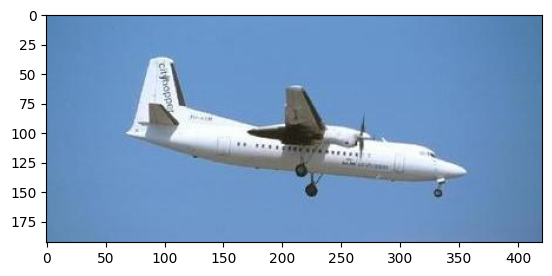

In [128]:
selected_image_id = int(input("Enter image ID: "))
sample_image, sample_label = dataset[selected_image_id]
plt.imshow(sample_image)
plt.show()


In [129]:
# Class transform to partition image into rows x cols grid


class GridPartition:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols

    def __call__(self, img):
        img_width, img_height = img.size
        cell_width = img_width // self.cols
        cell_height = img_height // self.rows

        grids = []
        for i in range(self.rows):
            for j in range(self.cols):
                left = j * cell_width
                top = i * cell_height
                right = left + cell_width
                bottom = top + cell_height
                grid = img.crop((left, top, right, bottom))
                grids.append(grid)

        return grids


### Feature model 1: Color moments

In [130]:
from scipy.stats import skew


def compute_color_moments(image):
    image = np.array(image)  # Convert PIL Image to NumPy array
    moments = []

    for channel in range(3):  # Iterate over RGB channels
        channel_data = image[:, :, channel]
        mean = np.mean(channel_data)
        std_dev = np.std(channel_data)
        skewness = skew(channel_data, axis=None)
        moments.append([mean, std_dev, skewness])

    return moments


# Iterate over grid cells and return as 1-d array for easier resizing by torch
def compute_color_moments_for_grid(grid):
    color_moments = [compute_color_moments(grid_cell) for grid_cell in grid]
    return np.array(color_moments).flatten()


In [131]:
def combine_color_moments(grid_color_moments):
    return torch.Tensor(grid_color_moments).view(
        10, 10, 3, 3
    )  # resize as needed: 10x10 grid, 3 channels per cell, 3 moments per channel


Composed color moment transform (CM10x10)

In [133]:
CM_transform = transforms.Compose(
    [
        transforms.Resize((100, 300)),  # resize to H:W=100:300
        GridPartition(
            rows=10, cols=10
        ),  # partition into grid of 10 rows, 10 columns as a list
        compute_color_moments_for_grid,
        combine_color_moments,
    ]
)

if np.array(sample_image).shape[2] >= 3:
    # no color moments for grayscale images
    cm_fd = CM_transform(sample_image)
else:
    cm_fd = torch.zeros((10, 10, 3, 3))

print(np.array(cm_fd))


[[[[ 8.98966675e+01  3.48893332e+00 -3.28439921e-01]
   [ 1.36396667e+02  2.87390375e+00 -1.31204709e-01]
   [ 1.86630005e+02  4.21502495e+00 -4.33173418e-01]]

  [[ 9.76766663e+01  1.95417213e+00 -4.62716408e-02]
   [ 1.44503326e+02  2.09045196e+00 -3.11197430e-01]
   [ 1.97606674e+02  2.93574905e+00 -2.41185650e-01]]

  [[ 1.02809998e+02  1.21129405e+00 -3.41436297e-01]
   [ 1.49716660e+02  1.22870755e+00 -3.97477776e-01]
   [ 2.03763336e+02  1.20857584e+00 -3.77465785e-01]]

  [[ 1.04209999e+02  9.01424825e-01 -1.24480568e-01]
   [ 1.51210007e+02  9.01424825e-01 -1.24480568e-01]
   [ 2.05210007e+02  9.01424825e-01 -1.24480568e-01]]

  [[ 1.03846664e+02  6.90281749e-01 -3.96895140e-01]
   [ 1.50733337e+02  7.27247477e-01 -6.87909067e-01]
   [ 2.04793335e+02  6.66299880e-01 -5.49638629e-01]]

  [[ 1.03613335e+02  9.07646537e-01  1.37317646e+00]
   [ 1.50093338e+02  5.92696309e-01 -4.12283629e-01]
   [ 2.04360001e+02  6.45806968e-01  1.27313507e+00]]

  [[ 1.02626663e+02  7.44281888e-0

(note that skewness is NaN when all elements are equal i.e. std. dev. = 0)

#### Visualizing color moments - stacked bar chart

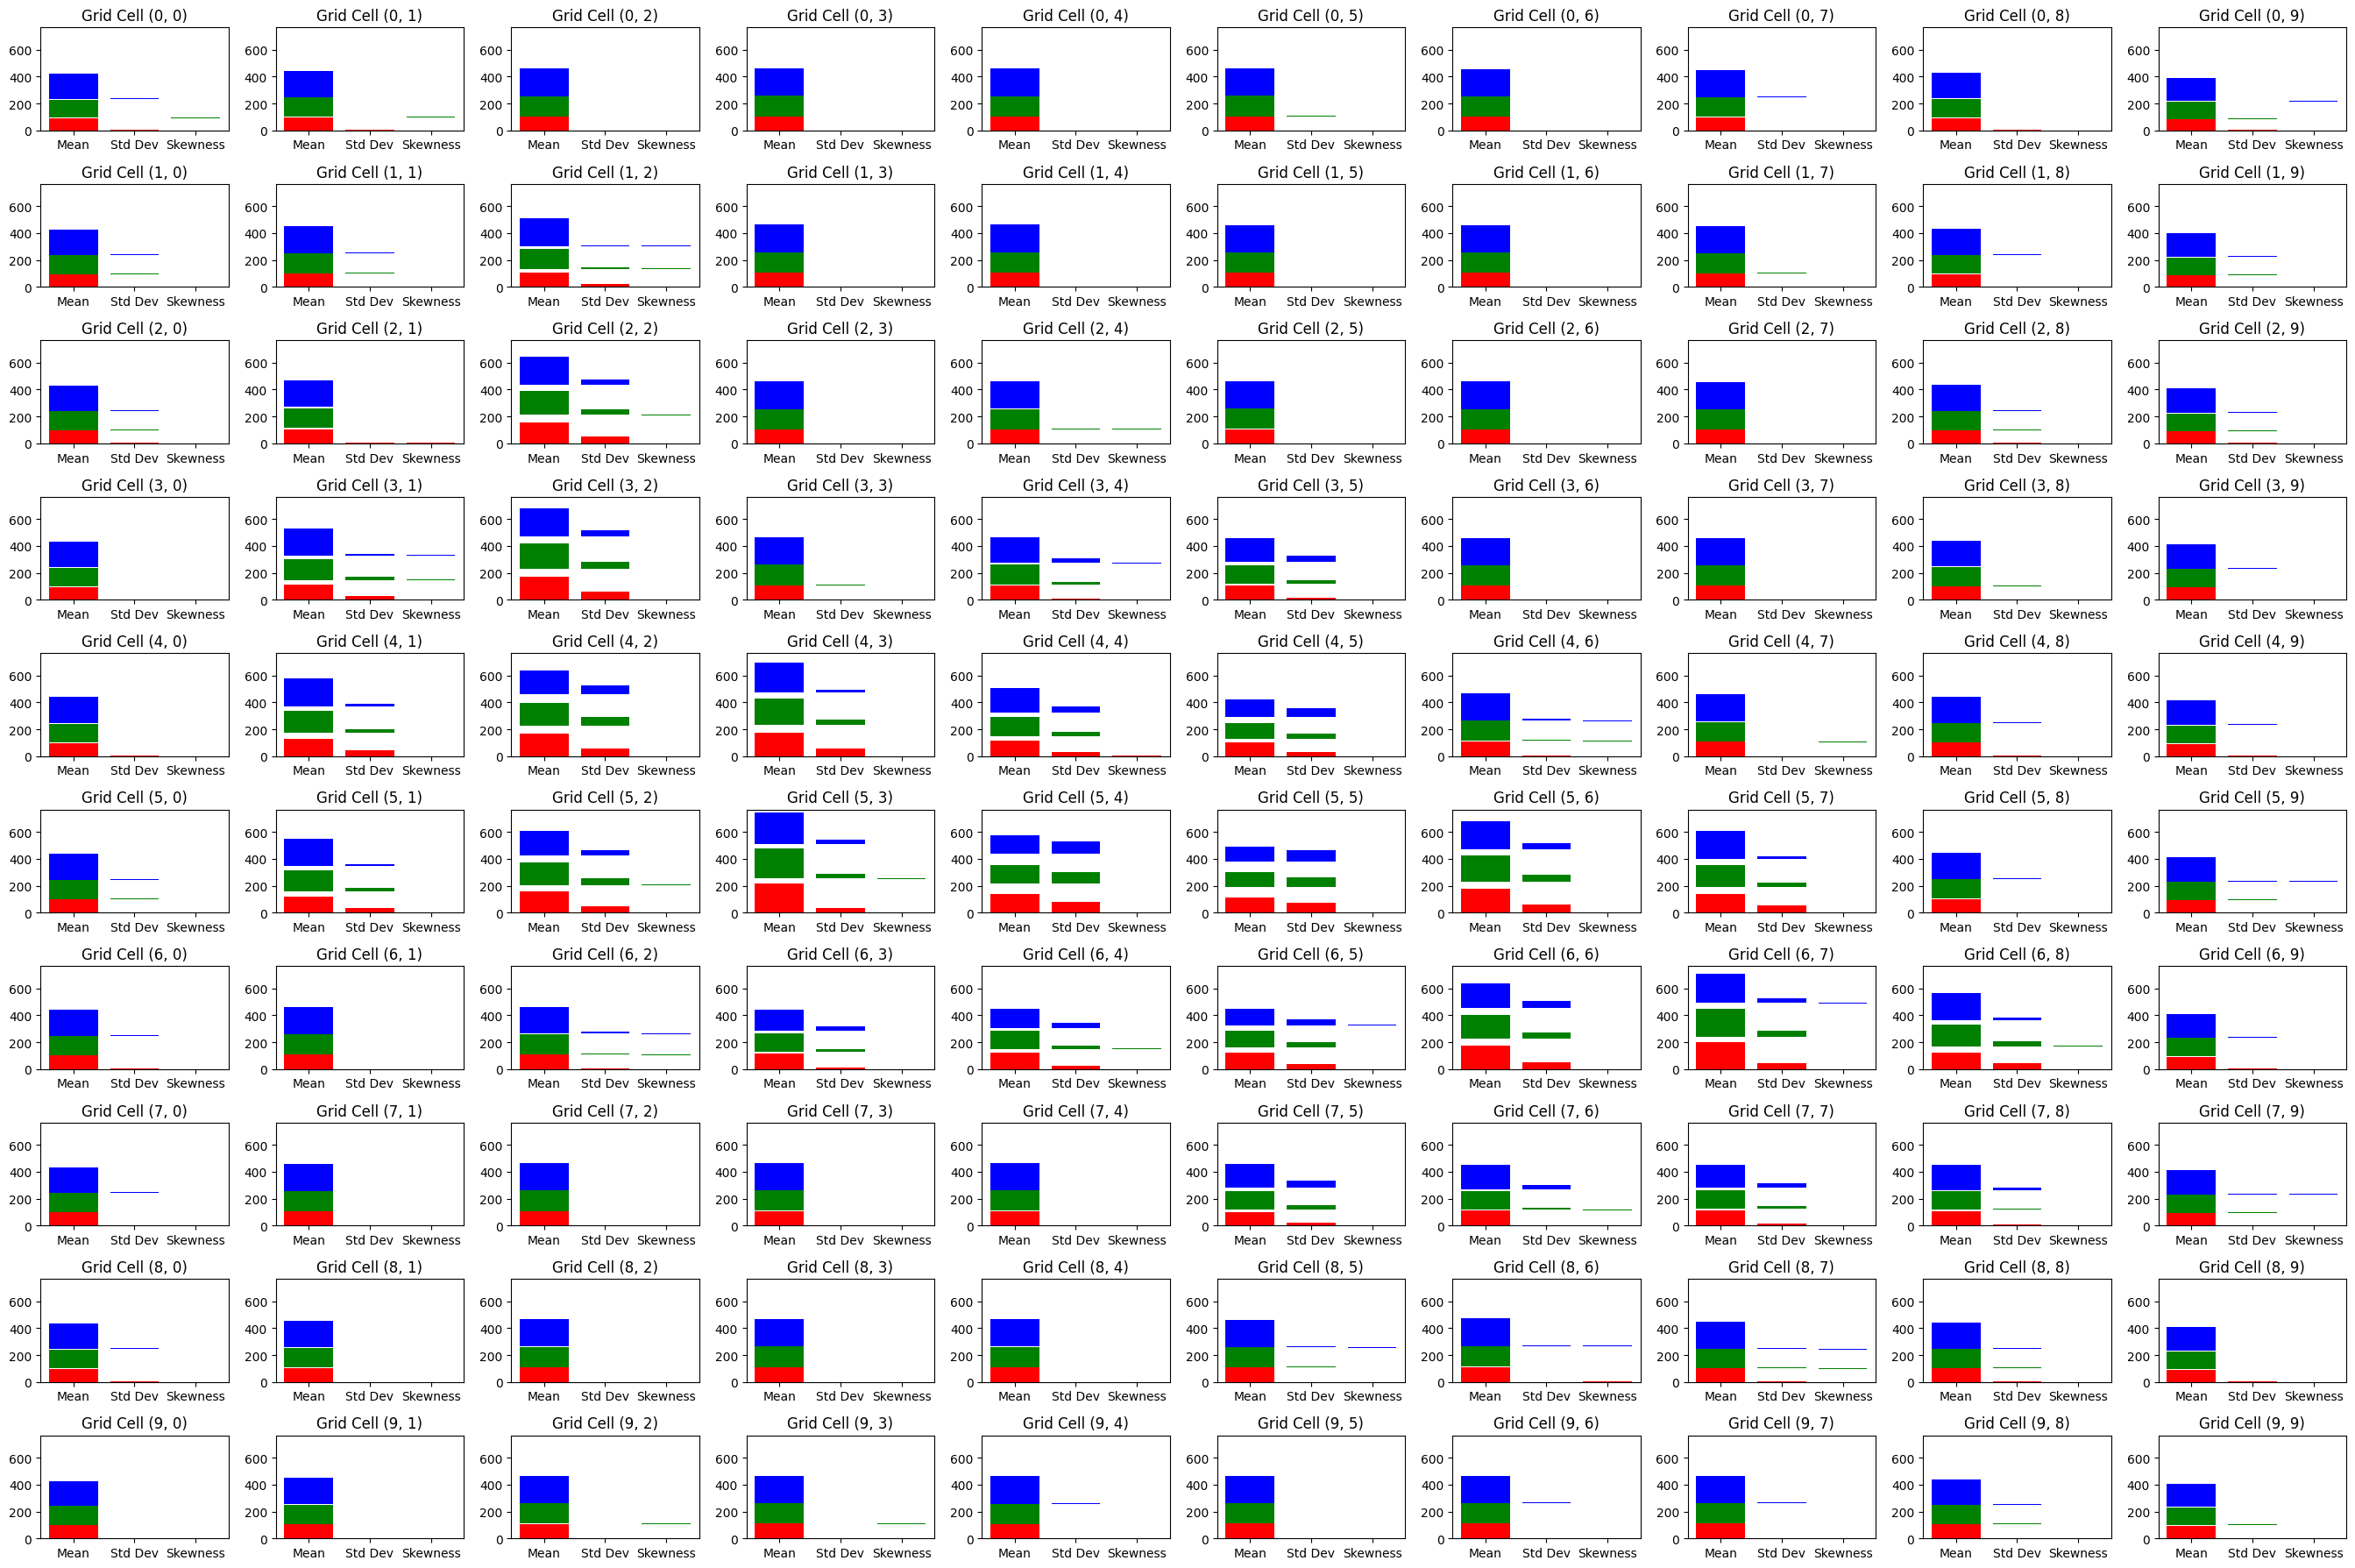

In [145]:
# cm_fd should be a NumPy array of shape (M, N, 3, 3), where (M, N) is the grid size

# Define the number of grid cells (M and N)
M, N = cm_fd.shape[:2]

# Create subplots for each color moment (mean, standard deviation, skewness)
fig, axes = plt.subplots(M, N, figsize=(27, 18))

# Loop through each grid cell and visualize the color moments as stacked bar charts
for i in range(M):
    for j in range(N):
        moments = cm_fd[i, j]
        colors = ["red", "green", "blue"]

        for c in range(3):
            ax = axes[i, j]
            ax.bar(
                ["Mean", "Std Dev", "Skewness"],
                moments[c],
                color=colors[c],
                bottom=np.sum(np.array(moments[:c])),
            ) # stack channels
            ax.set_ylim(
                0, 3 * 255
            )  # since max possible meanset can be [255, 255, 255] for entirely white grid cell
            ax.set_title(f"Grid Cell ({i}, {j})")

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()


Feature model 2: Histogram Oriented Gradients (HOG)

In [146]:
def compute_gradient_histogram(grid_cell):
    histograms = []

    # Convert grid cell to NumPy array
    grid_array = np.array(grid_cell, dtype=np.uint8)

    # Compute the gradient using first-order central differences
    dx = cv2.Sobel(
        grid_array, cv2.CV_32F, dx=1, dy=0, ksize=1
    )  # first order x derivative = [-1, 0, 1]
    dy = cv2.Sobel(
        grid_array, cv2.CV_32F, dx=0, dy=1, ksize=1
    )  # first order y derivative = [-1, 0, 1]^T

    # Compute magnitude and direction of gradients
    magnitude = np.sqrt(dx**2 + dy**2)
    direction = np.arctan2(dy, dx) * 180 / np.pi  # in degrees

    # Compute HOG - 9 bins, counted across the range of -180 to 180 degrees, weighted by gradient magnitude
    histogram, _ = np.histogram(direction, bins=9, range=(-180, 180), weights=magnitude)

    histograms.append(histogram)

    return histograms


In [147]:
def compute_histograms_for_grid(grid):
    histograms = [compute_gradient_histogram(grid_cell) for grid_cell in grid]
    return np.array(histograms).flatten()


In [148]:
def combine_histograms(grid_histograms):
    return torch.Tensor(grid_histograms).view(10, 10, 9)


In [149]:
HOG_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),  # grayscale transform
        transforms.Resize((100, 300)),  # resize to H:W=100:300
        GridPartition(
            rows=10, cols=10
        ),  # partition into grid of 10 rows, 10 columns as a list
        compute_histograms_for_grid,
        combine_histograms,
    ]
)

hog_fd = HOG_transform(sample_image)
print(np.array(hog_fd))


[[[0.00000000e+00 1.41421354e+00 1.52360678e+01 1.77924175e+01
   1.45000000e+02 5.03193283e+01 5.61803398e+01 8.22677231e+00
   1.10000000e+01]
  [0.00000000e+00 2.82842708e+00 1.00000000e+01 1.97989902e+01
   1.19324554e+02 3.15269585e+01 6.49442749e+01 1.66076984e+01
   2.01622772e+01]
  [0.00000000e+00 9.89949512e+00 2.22360687e+01 2.00284843e+01
   5.30000000e+01 3.74580383e+01 5.79442711e+01 1.49639902e+01
   2.30000000e+01]
  [2.23606801e+00 7.89292240e+00 1.01000000e+02 1.35497761e+01
   3.00000000e+01 1.86142712e+01 5.52360687e+01 2.06208439e+01
   4.82360687e+01]
  [2.23606801e+00 1.01289902e+01 7.44721375e+01 2.82842708e+00
   1.60000000e+01 2.82842708e+00 2.30000000e+01 0.00000000e+00
   1.40000000e+01]
  [0.00000000e+00 7.30056286e+00 3.94721375e+01 1.41421354e+00
   1.50000000e+01 0.00000000e+00 4.00000000e+00 0.00000000e+00
   2.40000000e+01]
  [0.00000000e+00 5.65685415e+00 5.70000000e+01 1.41421354e+00
   8.00000000e+00 1.41421354e+00 4.10000000e+01 6.47870874e+00
   2

Visualizing HOG as histograms

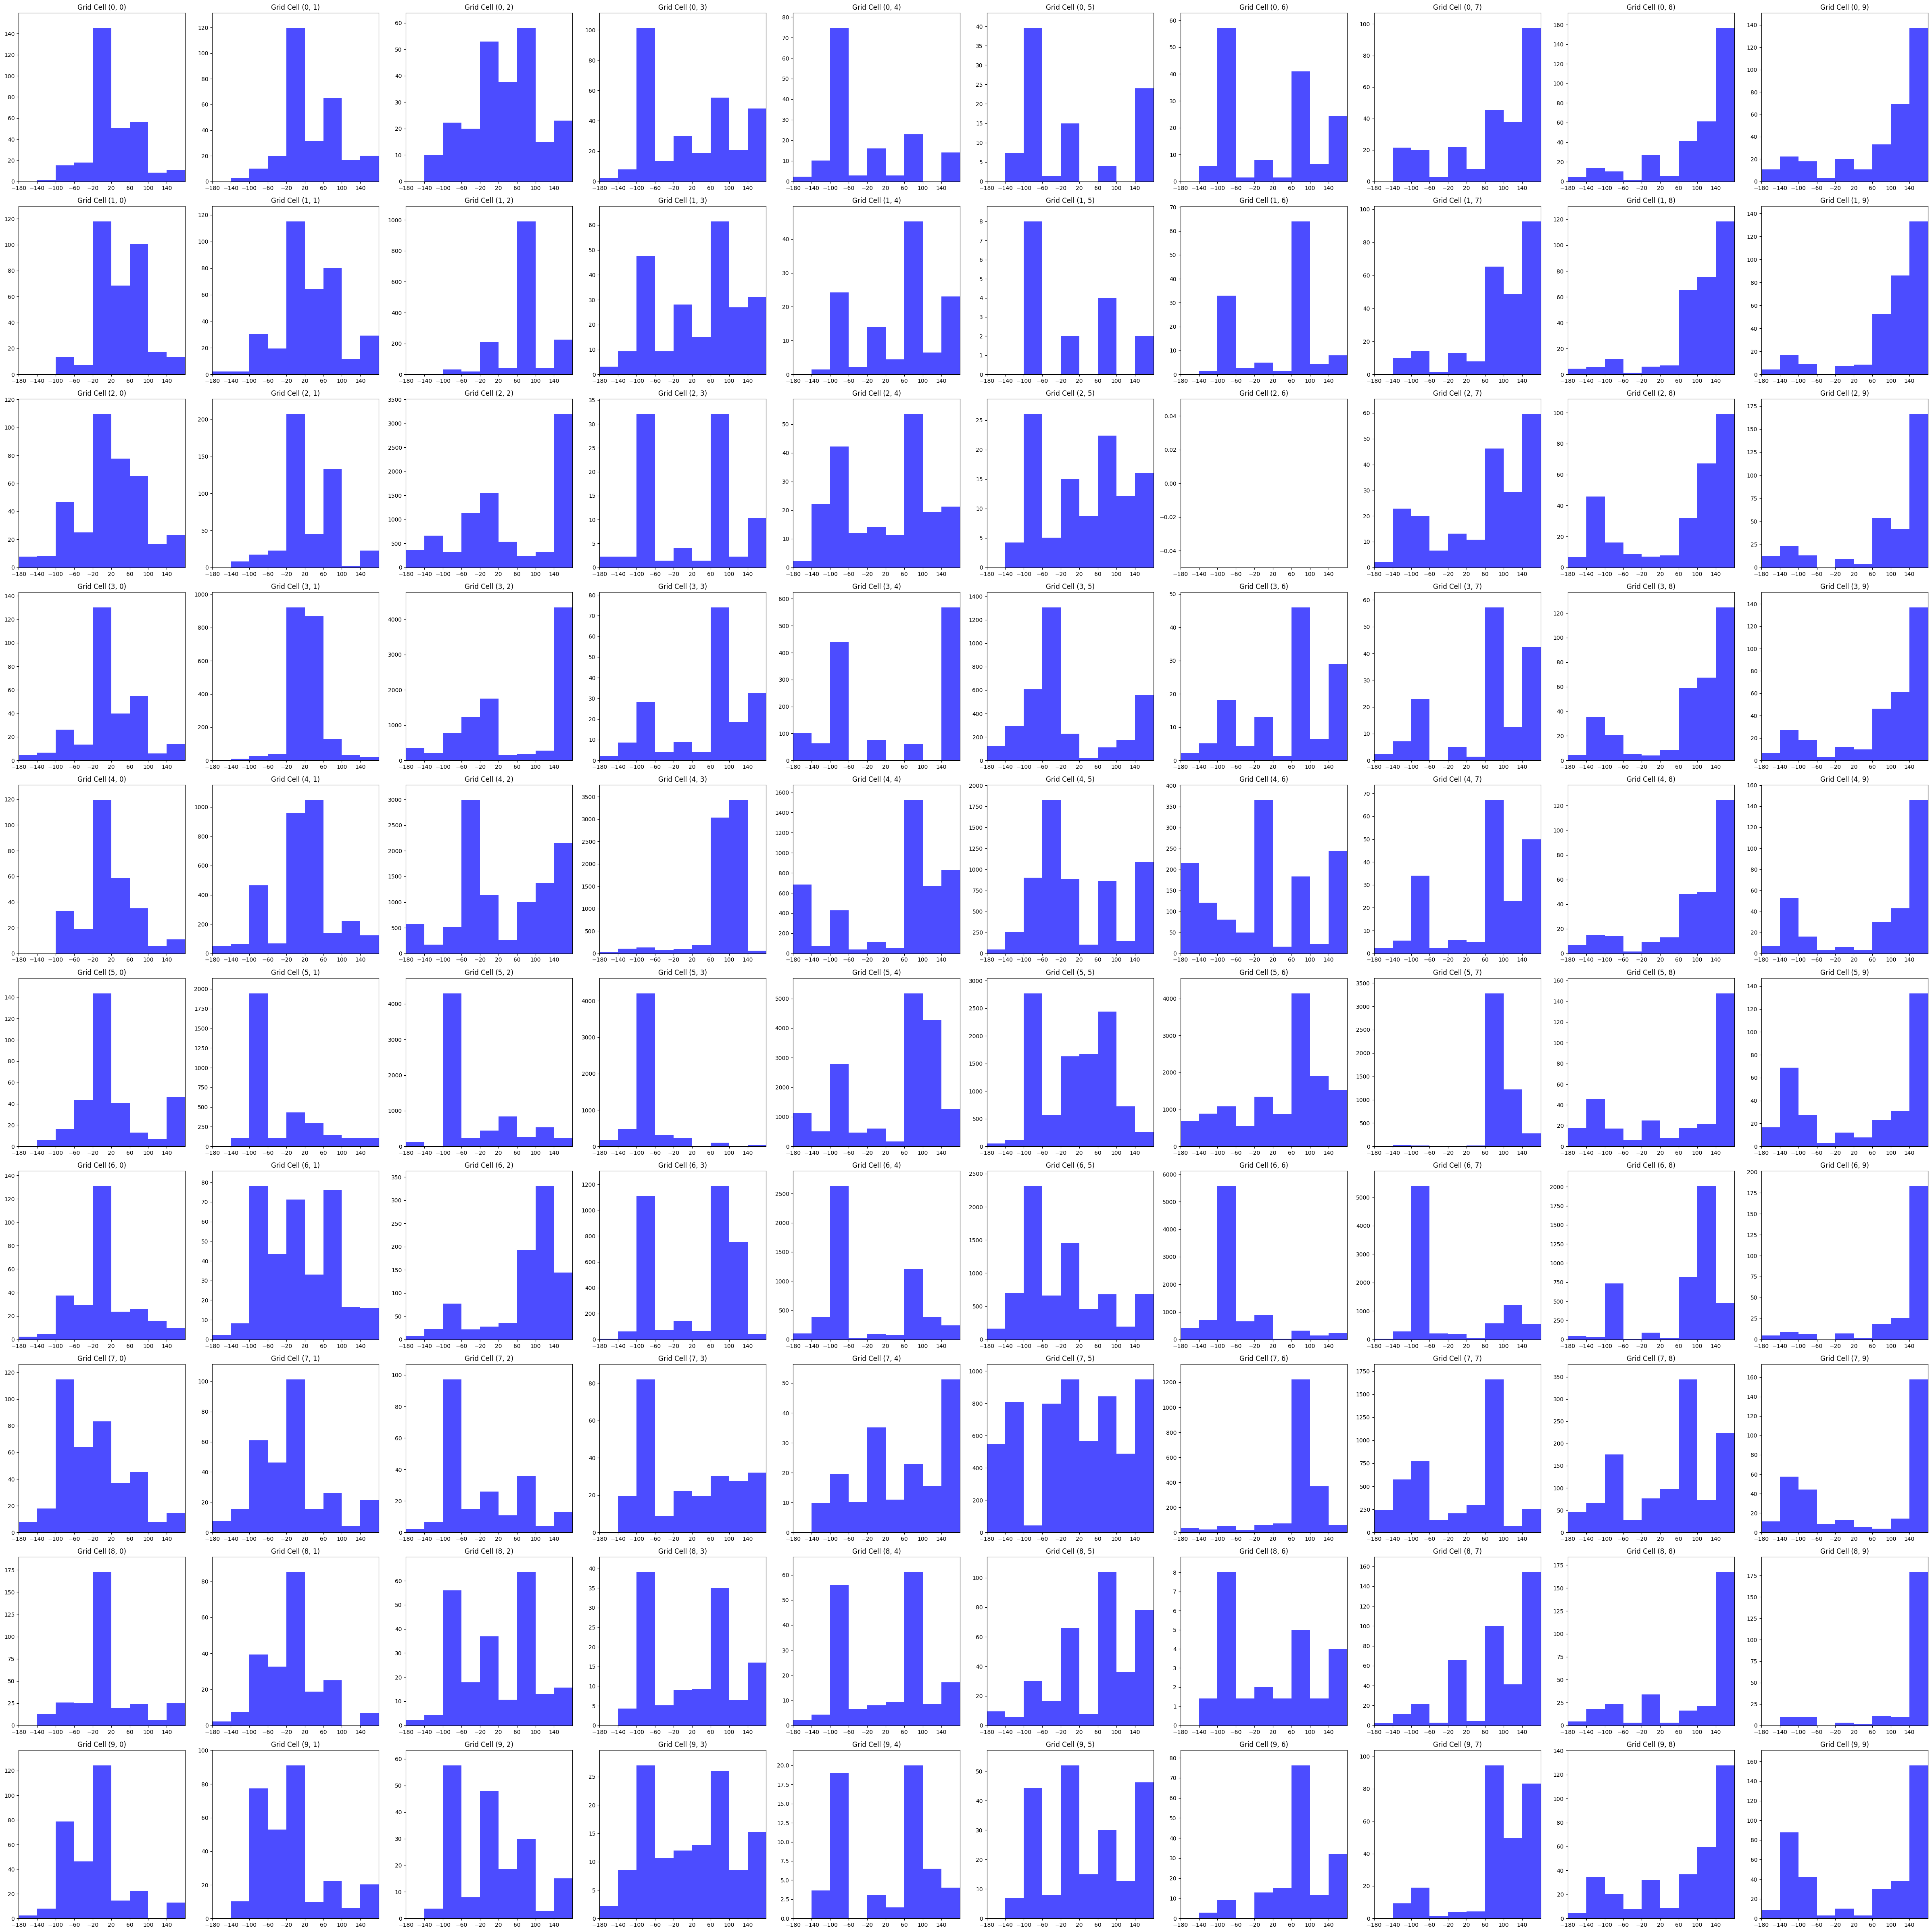

In [150]:
# # The 'hog' should now contain the 10x10x9 feature descriptor
# # Reshape it to a 10x10 grid of histograms, each of shape (9,)
histograms = np.array(hog_fd.reshape(10, 10, 9))

# # Visualize the histograms
fig, axes = plt.subplots(10, 10, figsize=(48, 48))
for i in range(10):
    for j in range(10):
        histogram = histograms[i, j]
        angles = np.linspace(-180, 180, 9, endpoint=False)

        axes[i, j].bar(angles, histogram, width=40, align="edge", color="b", alpha=0.7)
        axes[i, j].set_xlim(-180, 180)
        axes[i, j].set_ylim(0, np.max(histogram) * 1.1)
        axes[i, j].set_xticks([-180, -140, -100, -60, -20, 20, 60, 100, 140])
        axes[i, j].set_title(f"Grid Cell ({i}, {j})")

plt.tight_layout()
plt.show()


### Visualizing HOG gradient directions as an arrow overlay

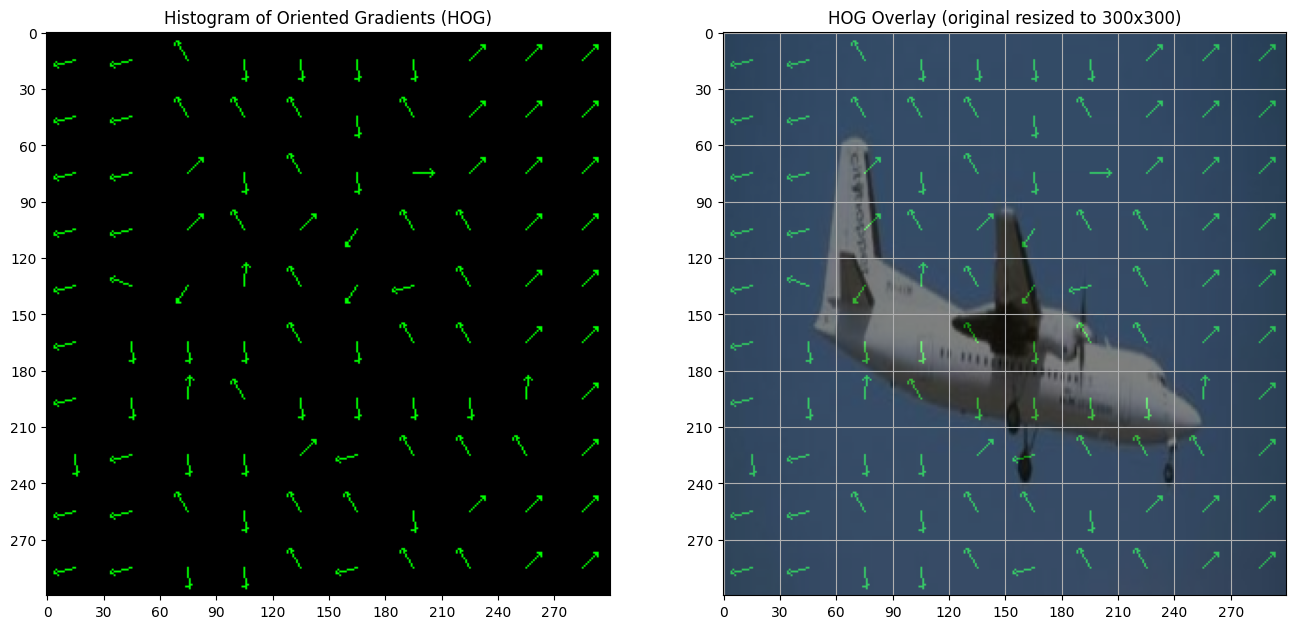

In [156]:
# Create a blank canvas to visualize the HOG features
block_size = 30
canvas = np.zeros((10 * block_size, 10 * block_size, 3), dtype=np.uint8)

# Define the arrow properties
base_arrow_length = block_size * 3 / 4  # Adjust as needed
arrow_color = (0, 255, 0)  # Green arrows for gradient direction

# Loop through each block in the HOG feature descriptor
for i in range(10):
    for j in range(10):
        block = hog_fd[i, j]
        x, y = j * block_size, i * block_size  # Top-left corner of the block

        # Compute the center position of the block
        center_x = x + block_size // 2
        center_y = y + block_size // 2

        # Find n most dominant directions (pairs of index and gradient magnitude in that direction)
        num_dir = 1
        dominant_directions = [pair for pair in sorted(
                list(enumerate(block)), key=lambda x: x[1], reverse=True
            )[:num_dir]
        ]

        for idx, (direction, magnitude) in enumerate(dominant_directions):
            arrow_thickness = num_dir - idx # decreasing thickness
            
            # Compute end points
            # arrow_start_x = int(
            #     center_x - ((base_arrow_length * np.cos(np.deg2rad(direction * 40))) / 2)
            # )
            # arrow_start_y = int(
            #     center_y - ((base_arrow_length * np.sin(np.deg2rad(direction * 40))) / 2)
            # )
            arrow_end_x = int(
                center_x
                + ((base_arrow_length * np.cos(np.deg2rad(direction * 40))) / 2)
            )
            arrow_end_y = int(
                center_y
                + ((base_arrow_length * np.sin(np.deg2rad(direction * 40))) / 2 )
            )

            # Draw the arrow on the canvas
            cv2.arrowedLine(
                canvas,
                (center_x, center_y),
                # (arrow_start_x, arrow_start_y),
                (arrow_end_x, arrow_end_y),
                arrow_color,
                thickness=arrow_thickness,
                tipLength=0.2,
            )

# Display the canvas with HOG arrows visualization alongside HOG overlay over resized image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=False)

ax1.imshow(canvas)
ax1.set_title('Histogram of Oriented Gradients (HOG)')

ax2.imshow(transforms.Resize((300,300))(sample_image))
ax2.imshow(canvas, alpha=0.5) # overlay HOG on image
# ax.imshow(transforms.Resize((300, 300))(sample_image))
ax2.set_title('HOG Overlay (original resized to 300x300)')

ax1.set_xticks(range(0, 300, 30))
ax1.set_yticks(range(0, 300, 30))
ax2.set_xticks(range(0, 300, 30))
ax2.set_yticks(range(0, 300, 30))
plt.grid()
plt.show()


## Working with ResNet50

In [157]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    865 MiB |    865 MiB |   1253 MiB | 397887 KiB |
|       from large pool |    671 MiB |    671 MiB |    920 MiB | 254816 KiB |
|       from small pool |    193 MiB |    212 MiB |    333 MiB | 143071 KiB |
|---------------------------------------------------------------------------|
| Active memory         |    865 MiB |    865 MiB |   1253 MiB | 397887 KiB |
|       from large pool |    671 MiB |    671 MiB |    920 MiB |

In [158]:
import torchvision.models as models

# Load model
model = models.resnet50(models.ResNet50_Weights.DEFAULT)

# use GPU (Nvidia)
if torch.cuda.is_available():
    dev = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    dev = torch.device("cpu")

print(f"Using {dev}")
model = model.to(dev)

# ResNet architecture in brief
model.eval()


Using cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### ResNet50 - Feature extractor module (for ease of use - attach hooks at multiple layers at once)

In [159]:
# Generalized feature extractor module for any PyTorch model

class FeatureExtractor(torch.nn.Module):
    def __init__(self, model, layers):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {
            layer: torch.empty(0) for layer in layers
        }  # store layer outputs here

        # Create hooks for all specified layers at once
        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]  # get actual layer in the model
            layer.register_forward_hook(
                self.save_outputs_hook(layer_id)
            )  # register feature extractor hook on layer

    # Hook to save output of layer
    def save_outputs_hook(self, layer_id):
        def fn(_module, _input, output):
            self._features[layer_id] = output

        return fn

    # Forward pass returns extracted features
    def forward(self, x):
        _ = self.model(x)
        return self._features


Resize image to 224x224 with 3 channels for ResNet50

In [160]:
resized_image = (
    torch.Tensor(np.array(transforms.Resize((224, 224))(sample_image)).flatten())
    .view(1, 3, 224, 224)
    .to(dev)
)


In [162]:
# Attach all hooks on model and extract features

resnet_features = FeatureExtractor(model=model, layers=["avgpool", "layer3", "fc"])

features = resnet_features(resized_image)

print({name: output.shape for name, output in features.items()})


{'avgpool': torch.Size([1, 2048, 1, 1]), 'layer3': torch.Size([1, 1024, 14, 14]), 'fc': torch.Size([1, 1000])}


ResNet-AvgPool-1024

In [163]:
avgpool_2048 = features["avgpool"]

# Reshape the vector into row pairs of elements and average across rows
avgpool_1024 = torch.mean(avgpool_2048.view(-1, 2), axis=1)

print(avgpool_2048.flatten())
print(avgpool_1024)


tensor([1.8399, 8.7920, 0.0692,  ..., 0.0000, 0.0000, 0.4238], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
tensor([5.3159, 0.0346, 0.5737,  ..., 0.0000, 0.0000, 0.2119], device='cuda:0',
       grad_fn=<MeanBackward1>)


ResNet-Layer3-1024

In [164]:
layer3_1024_14_14 = features["layer3"]

# Reshape the vector into 1024 rows of 196 elements and average across rows
layer3_1024 = torch.mean(layer3_1024_14_14.view(1024, -1), axis=1)

print(layer3_1024_14_14)
print(layer3_1024)


tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 5.0407,  8.4676,  8.9004,  ..., 11.0762,  9.5168, 11.4591],
          [ 4.8538,  9.3801, 10.1979,  ..., 18.1353, 10.1105, 13.3719],
          [ 6.2345, 13.2864, 13.7493,  ..., 19.6763, 15.1503, 13.7038],
          ...,
          [12.7917, 28.0994, 30.1812,  ..., 23.6287, 21.4789, 20.7834],
          [ 9.0382, 19.9966, 26.6109,  ..., 23.3203, 19.5199, 18.7572],
          [ 6.4684, 16.9173, 14.7637,  ..., 13.9358,  8.7940, 11.2343]],

         [[ 2.3567, 10.6136, 42.1683,  ..., 10.7147, 11.1157,  2.5210],
          [ 8.7863,  9.3639, 3

ResNet-FC-1000

In [165]:
fc_1000 = features['fc']

print(fc_1000)

tensor([[-1.9137e+01,  2.6573e+01,  1.2918e+01,  2.3530e+01,  2.4001e+01,
          3.2967e+01,  3.8136e+00,  5.1861e+00, -1.3473e+01,  4.0824e+01,
          2.2985e+00, -2.8794e+01, -7.9621e+00,  9.5298e+00, -1.1334e+01,
         -3.7700e+00, -2.8737e+01,  5.3688e+00, -2.2668e-01,  3.1083e+01,
          1.2332e+01,  6.0961e+00,  1.2618e+01,  1.2539e+01,  4.4857e-01,
         -6.1363e+00, -3.6046e+01,  1.5961e+01,  2.1800e+01,  3.8819e+01,
         -1.5190e+01,  1.5157e+01,  1.2280e+01,  9.7240e+00,  2.5503e+01,
          1.7647e+00,  1.3362e+01, -2.4889e+01,  7.3737e+01,  1.0355e+01,
         -2.1421e+01,  4.3789e+01,  4.3061e+01,  6.2216e+01, -1.0180e+01,
         -1.6713e+01, -1.6305e+01, -7.5167e+00, -1.7158e+00,  1.4992e+01,
         -1.0222e+00,  6.6237e+00,  4.1793e+01,  4.2032e+01, -5.3093e+01,
          9.4202e+00, -1.1857e+01, -4.3591e+01,  1.4767e+01,  1.9185e+01,
          2.0064e+02,  2.3772e+01,  1.1698e+01, -5.8784e+00,  3.5569e+01,
          4.8605e+01,  9.0204e+00, -1.